In [1]:
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from chamfer_distance import ChamferDistance
from torch.autograd import Variable
import glob
import torch.nn.functional as F
from models import Encoder, Tnet, Decoder

In [2]:
l = glob.glob("/datasets/cs253-wi20-public/ShapeNet_pointclouds/*/*/*2048.npy")

class PointCloudDataset(Dataset):

    def __init__(self, lis= None):
        
        point_clouds = []
        for file_name in lis:

            points = np.load(file_name)
            point_clouds.append(points)

        self.point_clouds = np.array(point_clouds, dtype='float64')
        self.point_clouds = np.transpose(self.point_clouds, (0, 2, 1))
        
    def __len__(self):
        return len(self.point_clouds)

    def __getitem__(self, idx):
        return self.point_clouds[idx]

In [3]:
class EarlyStopping():
    """
    Early Stopping to terminate training early under certain conditions
    """

    def __init__(self, min_delta=0, patience=50):
        
        """
        EarlyStopping callback to exit the training loop if training or
        validation loss does not improve by a certain amount for a certain
        number of epochs
        Arguments
        ---------
        min_delta : float
            minimum change in monitored value to qualify as improvement.
            This number should be positive.
        patience : integer
            number of epochs to wait for improvment before terminating.
            the counter be reset after each improvment
        """
        
        self.min_delta = min_delta
        self.patience = patience
        self.wait = 0
        self.best_loss = 1e-15
        self.stopped_epoch = 0

    def on_train_begin(self):
        self.wait = 0
        self.best_loss = 1e15

    def on_epoch_end(self, epoch, current_loss):

        if current_loss is None:
            pass
        else:
            if (current_loss - self.best_loss) < -self.min_delta:
                self.best_loss = current_loss
                self.wait = 1
            else:
                if self.wait >= self.patience:
                    return True
                self.wait += 1
        
        return False

In [4]:
class ChamferLoss(nn.Module):

    # based on https://github.com/345ishaan/DenseLidarNet/blob/master/code/chamfer_loss.py
    def __init__(self):
        super(ChamferLoss, self).__init__()
        self.use_cuda = torch.cuda.is_available()        

    def forward(self,preds,gts):
        P = self.batch_pairwise_dist(gts, preds)
        mins, _ = torch.min(P, 1)
        loss_1 = torch.sum(mins)
        mins, _ = torch.min(P, 2)
        loss_2 = torch.sum(mins)
        return loss_1 + loss_2


    def batch_pairwise_dist(self,x,y):
        x = x.transpose(2, 1)
        y = y.transpose(2, 1)
        _, num_points_x, _ = x.size()
        _, num_points_y, _ = y.size()
        xx = torch.bmm(x, x.transpose(2,1))
        yy = torch.bmm(y, y.transpose(2,1))
        zz = torch.bmm(x, y.transpose(2,1))
        if self.use_cuda:
            dtype = torch.cuda.LongTensor
        else:
            dtype = torch.LongTensor
        diag_ind_x = torch.arange(0, num_points_x).type(dtype)
        diag_ind_y = torch.arange(0, num_points_y).type(dtype)
        rx = xx[:, diag_ind_x, diag_ind_x].unsqueeze(1).expand_as(zz.transpose(2,1))
        ry = yy[:, diag_ind_y, diag_ind_y].unsqueeze(1).expand_as(zz)
        P = (rx.transpose(2,1) + ry - 2*zz)
        return P

In [5]:
point_cloud_dataset = PointCloudDataset(l)
dataloader = DataLoader(point_cloud_dataset, batch_size=32, shuffle=True)
#enc = Encoder()
#dec = Decoder()
enc = torch.load('encoder-Copy1')
dec = torch.load('decoder-Copy1')
#chamferDist = ChamferDistance()
#early_stopping = EarlyStopping(patience=50)
criterion = ChamferLoss()
num_epochs = 1000
learning_rate = 1e-6

optimizere = torch.optim.Adam(enc.parameters(), lr=learning_rate)
optimizerd = torch.optim.Adam(dec.parameters(), lr=learning_rate)
if torch.cuda.is_available():
    enc = enc.cuda()
    dec = dec.cuda()
loss_list = []
for epoch in range(num_epochs):
    
   # if epoch == 0:
  #      early_stopping.on_train_begin()

    running_loss = 0.0
    
    for data in dataloader:
        if torch.cuda.is_available():
            data = data.cuda()
            
        train_output = enc(data.float())
        out= dec(train_output)
        #dist1, dist2 = chamferDist(out.float(), data.float())
        #loss = (torch.mean(dist1)) + (torch.mean(dist2))
        loss = criterion(out.double(), data.double())
        optimizere.zero_grad()
        optimizerd.zero_grad()
        loss.backward()
        optimizere.step()
        optimizerd.step()
        
        running_loss += loss.data.detach() 
    
    loss_list.append(running_loss / data.shape[0])
    
  #  if early_stopping.on_epoch_end(epoch + 1, running_loss):
   #     print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss_list[-1]))
  #      print('Terminated Training for Early Stopping at Epoch %04i' % (epoch + 1))
    torch.save(enc, 'encoder')
    torch.save(dec, 'decoder')
            
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss_list[-1]))    

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv1d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-pac

epoch [1/1000], loss:8668.5727
epoch [2/1000], loss:8685.7940
epoch [3/1000], loss:8680.6466
epoch [4/1000], loss:8662.2608
epoch [5/1000], loss:8750.1693
epoch [6/1000], loss:8680.6999
epoch [7/1000], loss:8667.8493
epoch [8/1000], loss:8675.0653
epoch [9/1000], loss:8690.5806
epoch [10/1000], loss:8702.8672


KeyboardInterrupt: 

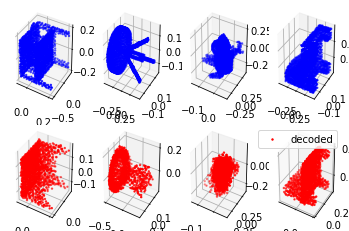

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

inp  = next(iter(dataloader)).float()
train_output = enc(inp.cuda().float())
out= dec(train_output)
for i in range(4):
    ax = fig.add_subplot(2, 4, i+1, projection='3d')
    data = inp[i].numpy()
    ax.scatter(data[0], data[1], data[2], zdir='z', s=2, c='b', label='ground truth')
    data = out[i].cpu().detach().numpy()
    ax = fig.add_subplot(2, 4, i+5, projection='3d')
    ax.scatter(data[0], data[1], data[2], zdir='z', s=2, c='r', label='decoded')
    
ax.legend()
plt.show()